###  K-means with Euclidena distance as proximity measure

In [312]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

In [313]:
def getEucledian(a,b):
    #print(a,b)
    total = 0;
    for i in range(0,len(a)):
        diff = b[i] - a[i];
        total += diff * diff;
    return np.sqrt(total)

In [314]:
def normContinuousAttributes(df,labels):
    for i in labels:
        df[i] = df[[i]].apply(lambda x : (x - np.min(x))/(np.max(x) - np.min(x)))
    return df

In [315]:
def clusterSSE(x,k_clusters,k_centers):
    total = {} 
    for key,value in k_clusters.items():
        s = 0
        center = k_centers[key]
        for i in value:
            s = s + math.pow(getEucledian(x[i],center),2)
        total[key] = s
    return total       

In [316]:
def overallSSE(cluster_sse):
    s = 0
    for key,value in cluster_sse.items():
        s = s + cluster_sse[key]
    return s

In [317]:
def SSB(x,k_clusters,k_centers):
    c = getMeanUsingIndex(x,list(range(0,len(x))))
    keys = list(k_centers.keys())
    s =  0
    for j in keys:
        t = len(k_clusters[j])
        s = s + (t * math.pow(getEucledian(k_centers[j],c),2))
    return s

In [318]:
def getMeanUsingIndex(x,indices):
    total = []
    for i in x[0]:
        total.append(0)
    #print(total)
    for i in indices:
        for j in range(0,len(total)):
            total[j] = total[j] + x[i][j]
    total = [f/len(indices) for f in total]
    return (total)

In [319]:
def anyCenterChanged(k_centers,new_centers):
    for key,value in k_centers.items():
        if(k_centers[key] != new_centers[key]):
            return True
    return False

In [320]:
def assignInputToClusters(x,k_centers):
    #keep track of clusters
    k_clusters = {}
    # print("Centers : ")
    # print(k_centers)
    dissimilarity = []
    #assign all input patterns to clusters
    for key,i in k_centers.items():
        for j in x:
            dissimilarity.append(getEucledian(i,j)) #eucledian similarity

    dissimilarity = np.reshape(dissimilarity,(len(k_centers),len(x)))
    df_dissim = pd.DataFrame(data=dissimilarity)
    #print(df_dissim)
    for i in range(1,df_dissim.shape[0]+1):
        k_clusters[i] = [];
    for i in df_dissim.columns:
        #print(df_dissim.nsmallest(1,i).index[0],end = " ")
        shortest_dist_index = df_dissim.nsmallest(1,i).index[0]
        k_clusters[shortest_dist_index+1].append(i)
    #print(k_clusters)
    new_centers = {}
    for key,value in k_clusters.items():
        #print(key,value)
        new_centers[key]  = getMeanUsingIndex(x,value)
#     print("New Centers : ")
#     print(new_centers)
    if(anyCenterChanged(k_centers,new_centers)):
        assignInputToClusters(x,new_centers)
    return (new_centers,k_clusters)

In [321]:
def recomputeDist(x,centers):
    dist = []
    for i in x:
        t = []
        for key,value in centers.items():
            t.append(getEucledian(i,value))
        dist.append(np.min(t))
    total = np.sum(dist)
    prob_dist = [d/total for d in dist]
    return dist,prob_dist

In [322]:
def kMeansPlusPlus(x,K,first_center):
    k_centers = {}
    #randomly select one center
    #k_centers[1] = rd.sample(x,1)[0]
    k_centers[1] = first_center
    #print("First center : " + str(k_centers[1]))
    #calculate distance of all points to this center
    dist = []
    for i in x:
        dist.append(math.pow(getEucledian(i,k_centers[1]),2))
    total = np.sum(dist)
    #get probability distribution for each point using the distance
    prob_dist = [d/total for d in dist]
    #select k centers using probability distribution
    j = 2
    index = list(range(0,len(x)))
    while(not(len(k_centers) == K)):
        i = np.random.choice(index,p=prob_dist)
        k_centers[j] = x[i]
        dist,prob_dist = recomputeDist(x,k_centers)
        j = j + 1
    return k_centers
    

In [323]:
def kMeans(x,K,kmeans_plus_plus,first_center):
    #select K number of input patterns as cluster centers randomly
    centers = rd.sample(x,K)
    k_centers = {}
    if(kmeans_plus_plus):
        k_centers = kMeansPlusPlus(x,K,first_center)
    else:
        k_centers = {}
        i = 1
        for j in centers:
            k_centers[i] = j
            i = i + 1
    (k_centers,k_clusters) = assignInputToClusters(x,k_centers)
    return (k_clusters,k_centers)


In [324]:
def getOutFrame(k_clusters):
    columns = ["Row ID","Cluster"]
    df_out = pd.DataFrame() 
    for key,values in k_clusters.items():
        t = []
        for i in values:
            t.append(key)
        df = pd.DataFrame({"Row ID" : values, "Cluster" : t})
        df_out = df_out.append(df)
        df_out = df_out.sort_values("Row ID",ascending=True)
#     indices = df_out["Row ID"]
#     indices = [x+1 for x in indices]
#     df_out["Row ID"] = indices
    return df_out

In [325]:
def plotClusters(x,k_clusters,title,xlabel,ylabel):
    fig1 = plt.figure(1)
    for key,value in k_clusters.items():
        c = [x[index] for index in value]
        #print(c)
        plt.scatter(*zip(*c),label="Cluster " + str(key))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [326]:
def getTrueClusters(df,label):
    k_clusters = {}
    k_centers = {}
    clusters = set(df[label])
    #print(clusters)
    df_temp = df.drop(["ID",label],axis=1)
    x = df_temp.values.tolist()
    for i in clusters:
        a = df.loc[df[label] == i].index
        #print(a)
        k_clusters[i] = list(a)
        k_centers[i] = getMeanUsingIndex(x,list(a))
    #print(k_clusters)
    return k_clusters,k_centers

In [327]:
def crossTabMatrix(k_clusters,true_clusters):
    df = pd.DataFrame()
    t = []
    for key,value in k_clusters.items():
        for a,b in true_clusters.items():
            b3 = [val for val in value if val in b]
            t.append(len(b3))
    t = np.reshape(t,(len(k_clusters),len(true_clusters)))
    columns = list(true_clusters.keys())
    df_temp = pd.DataFrame(data=list(k_clusters.keys()),columns=["Cluster"])
    df = pd.DataFrame(data=t,columns=columns)
    df = pd.concat([df_temp,df],axis=1)
    df = df.set_index('Cluster')
    return df

In [328]:
df_tdh = pd.read_csv("wine.csv")
df_tdh = df_tdh.drop(["class"],axis=1)
#df_tdh['quality'] = df_tdh['quality'].map({3:1,4:2,5:3,6:4,7:5,8:6})
labels = ["fx_acidity","resid_sugar","free_sulf_d","tot_sulf_d","pH","alcohol"]
df_tdh = normContinuousAttributes(df_tdh,labels)
true_clusters,true_centers = getTrueClusters(df_tdh,"quality")
df_tdh = df_tdh.drop(["ID","quality"],axis=1)
# df_tdh = pd.read_csv("TwoDimHard.csv")
# true_clusters,true_centers = getTrueClusters(df_tdh,"cluster")
# df_tdh = df_tdh.drop(["ID","cluster"],axis=1)
x = df_tdh.values.tolist()
# keys = true_centers.keys()
df_tdh.head()
#print(true_centers)

,fx_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sulf_d,tot_sulf_d,density,pH,sulph,alcohol
0,0.247788,0.70,0.00,0.068493,0.076,0.140845,0.098940,0.9978,0.606299,0.56,0.153846
1,0.283186,0.88,0.00,0.116438,0.098,0.338028,0.215548,0.9968,0.362205,0.68,0.215385
2,0.283186,0.76,0.04,0.095890,0.092,0.197183,0.169611,0.9970,0.409449,0.65,0.215385
3,0.584071,0.28,0.56,0.068493,0.075,0.225352,0.190813,0.9980,0.330709,0.58,0.215385
4,0.247788,0.70,0.00,0.068493,0.076,0.140845,0.098940,0.9978,0.606299,0.56,0.153846


In [329]:
true_sse = clusterSSE(x,true_clusters,true_centers)
print("True Cluster SSE : " + str(true_sse))
true_overall_sse = overallSSE(true_sse)
print("True Overall SSE : " + str(true_overall_sse))
true_ssb = SSB(x,true_clusters,true_centers)
print("True SSB : " + str(true_ssb))

True Cluster SSE : {3: 2.490928011284716, 4: 13.232662359786652, 5: 127.39168759959406, 6: 123.57078524465169, 7: 37.27221633035359, 8: 3.5785409047412915}
True Overall SSE : 307.53682045041205
True SSB : 29.482622058316192


In [330]:
x = df_tdh.values.tolist()
first_center = rd.sample(x,1)[0]
k = int(input("Enter K : "))
t = []
t1 = []
k_clusters =  {}
k_centers = {}
best_clusters = {}
best_centers = {}
best_sse = 300
best_cluster_sse = {}
best_ssb = 0
columns = ["Cluster","Overall SSE","SSB"]
#df_table = pd.DataFrame({"Cluster" : [], "Overall SSE" : [], "Overall SSB" : []})
df_table = pd.DataFrame()
n = 6
n1 = 5
for i in range(n1,n):
    print("Iteration : " + str(i))
    (k_clusters,k_centers) = kMeans(x,i,True,a)
    #print(k_centers)
    sse = clusterSSE(x,k_clusters,k_centers)
    print("Cluster SSE : " + str(sse))
    overall_sse = overallSSE(sse)
    print("Overall SSE : " + str(overall_sse))
    t.append(overall_sse)
    ssb = SSB(x,k_clusters,k_centers)
    print("SSB : " + str(ssb))
    t1.append(ssb)
    if(i == 5 ):
        best_sse = overall_sse
        best_clusters = k_clusters
        best_centers = k_centers
        best_ssb = ssb
        best_cluster_sse = sse
    df = pd.DataFrame({"Cluster" : "Assigned Cluster", "Overall SSE" : [overall_sse],"SSB" : [ssb]})
    df_table = df_table.append(df) 
    df = pd.DataFrame({"Cluster" : "True Cluster", "Overall SSE" : [true_overall_sse],"SSB" : [true_ssb]})
    df_table = df_table.append(df)
    df_table = df_table.set_index('Cluster')
df_cross = crossTabMatrix(k_clusters,true_clusters)
df_out = getOutFrame(k_clusters)
df_out.to_csv("output.csv")

Enter K : 4
Iteration : 5
Cluster SSE : {1: 97.7755132538427, 2: 13.498379102077333, 3: 3.8736245866563417, 4: 85.88880883118027, 5: 35.63871888255108}
Overall SSE : 236.67504465630773
SSB : 100.34439785242083


In [331]:
df_cross.head()

,3,4,5,6,7,8
Cluster,,,,,,
1,3,19,380,214,24,1
2,0,3,50,56,14,0
3,0,0,5,5,2,0
4,1,4,72,209,135,17
5,6,27,174,154,24,0


In [332]:
df_table.head()

,Overall SSE,SSB
Cluster,,
Assigned Cluster,236.675045,100.344398
True Cluster,307.536820,29.482622


In [333]:
best_overall_sse = np.min(t)
print("Overall SSE's : " + str(t))
print("Best SSE : " + str(best_overall_sse))
print("Average SSE : " + str(np.average(t)))
print("Worst SSE : " + str(np.max(t)))
best_overall_ssb = np.min(t1)
print("Overall SSB's : " + str(t1))
print("Best SSB : " + str(best_overall_ssb))
print("Average SSB : " + str(np.average(t1)))
print("Worst SSB : " + str(np.max(t1)))

Overall SSE's : [236.67504465630773]
Best SSE : 236.675044656
Average SSE : 236.675044656
Worst SSE : 236.675044656
Overall SSB's : [100.34439785242083]
Best SSB : 100.344397852
Average SSB : 100.344397852
Worst SSB : 100.344397852


In [334]:
#plt.subplot(1,1,1)
#plotClusters(x,k_clusters,"Clusters with K = " + str(k),"x1","x2")
#plt.subplot(1,1,2)
#plotClusters(x,true_clusters,"True Clusters with K = " + str(len(true_centers)),"x1","x2")
df_out.head()

,Cluster,Row ID
0,5,0
0,1,1
1,1,2
2,1,3
1,5,4


In [335]:
def plot(y,k_list,ylabel,title):
    my_xticks = k_list
    s = list(range(0,len(k_list)))
    plt.xticks(s, my_xticks)
    print(s,y)
    plt.plot(s,y)
    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [336]:
print(best_sse)
print(best_cluster_sse)
print(best_ssb)

236.67504465630773
{1: 97.7755132538427, 2: 13.498379102077333, 3: 3.8736245866563417, 4: 85.88880883118027, 5: 35.63871888255108}
100.34439785242083


[0] [236.67504465630773]


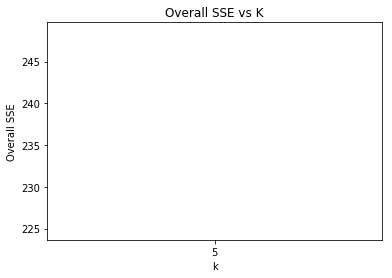

[0] [100.34439785242083]


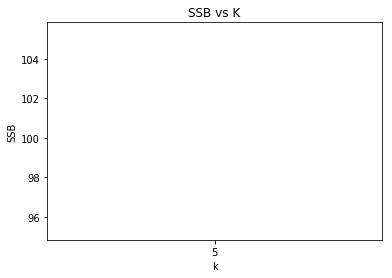

In [337]:
plot(t,list(range(n1,n)),"Overall SSE","Overall SSE vs K")
plot(t1,list(range(n1,n)),"SSB","SSB vs K")

In [338]:
df_cross = crossTabMatrix(best_clusters,true_clusters)
print(df_cross)

         3   4    5    6    7   8
Cluster                          
1        3  19  380  214   24   1
2        0   3   50   56   14   0
3        0   0    5    5    2   0
4        1   4   72  209  135  17
5        6  27  174  154   24   0


In [339]:
first_center

[0.17699115044247787,
 0.84,
 0.03,
 0.0958904109589041,
 0.059000000000000004,
 0.43661971830985913,
 0.14840989399293286,
 0.9952,
 0.6141732283464567,
 0.56,
 0.6000000000000001]